In [3]:
import xnemogcm
import xgcm
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.colors import LogNorm
import cmocean.cm as cmo
import xarray as xr
import datetime
import gsw
xr.set_options(keep_attrs=True)
plt.rcParams['font.size']=14

In [2]:
path=('../../MAUD_RISE_config/maud_v4/m36_ke2/section/')

ds_09=xr.open_mfdataset(path+'*2E_2009_m36.nc')
ds_09=ds_09.expand_dims(dim='t')
ds_09['year']=ds_09.t+2009
ds_09.coords['year']=ds_09.year

ds_14=xr.open_mfdataset(path+'*2E_2014_m36.nc')
ds_14=ds_14.expand_dims(dim='t')
ds_14['year']=ds_14.t+2014
ds_14.coords['year']=ds_14.year

bat=xr.open_dataset('../../MAUD_RISE_config/maud_v4/m36_mask/1_domain_cfg_50levels_new.nc')
bat.coords['nav_lon']=bat.nav_lon.mean(dim='y')
bat.coords['nav_lat']=bat.nav_lat.mean(dim='x')
bat=bat.swap_dims({'x':'x_c','y':'y_c','z':'z_c'})
xloc=268
bat=bat.isel(x_c=xloc)
deptht=bat.e3t_1d.cumsum(dim='z_c')- 0.5*bat.e3t_1d.isel(z_c=0)
bat['depth']=deptht
mask=xr.open_mfdataset('../../MAUD_RISE_config/maud_v4/m36_mask/mask*.nc')
mask=mask.isel(x_c=xloc)
ds_14=xr.merge((ds_14,bat.bathy_meter,bat.depth,mask))


In [8]:
ds=xr.concat((ds_09,ds_14),dim='t')
ds.coords['depth']=ds.depth
ds

<xarray.Dataset>
Dimensions:      (t: 2, y_c: 804, z_c: 50)
Coordinates:
    depth        (z_c) float64 0.5112 1.585 2.722 ... 5.499e+03 5.957e+03
    nav_lat      (y_c) float32 -70.54 -70.5 -70.49 ... -61.58 -61.57 -61.55
    nav_lon      float32 2.417
  * y_c          (y_c) int64 0 1 2 3 4 5 6 7 ... 796 797 798 799 800 801 802 803
    x_c          int64 268
  * z_c          (z_c) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
    glamt        (y_c) float64 2.417 2.417 2.417 2.417 ... 2.417 2.417 2.417
    gphit        (y_c) float64 -70.54 -70.5 -70.49 ... -61.58 -61.57 -61.55
    year         (t) int64 2009 2014
Dimensions without coordinates: t
Data variables:
    mask_ha_mod  (y_c) float64 dask.array<chunksize=(804,), meta=np.ndarray>
    mask_ha      (y_c) float64 dask.array<chunksize=(804,), meta=np.ndarray>
    mask_tr      (y_c) float64 dask.array<chunksize=(804,), meta=np.ndarray>
    bathy_meter  (y_c) float32 ...
    mask_tc      (y_c) float64 dask.array<chunksize=(804,), meta=np.ndarray>
    so           (t, z_c, y_c) float32 dask.array<chunksize=(1, 50, 804), meta=np.ndarray>
    thetao       (t, z_c, y_c) float32 dask.array<chunksize=(1, 50, 804), meta=np.ndarray>
    uo           (t, z_c, y_c) float32 dask.array<chunksize=(1, 50, 804), meta=np.ndarray>

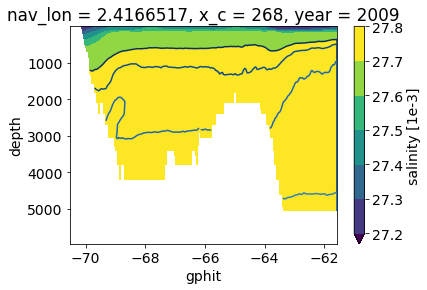

In [31]:
ds.sig0.isel(t=0).where(ds.depth<ds.bathy_meter).plot.contourf(x="gphit",y="depth",robust=True)
ds.sig0.isel(t=0).where(ds.depth<ds.bathy_meter).plot.contour(x="gphit",y="depth",levels=np.arange(27.7,27.9,0.01))
plt.gca().invert_yaxis()

In [11]:
# get indexes for beginning and end of defined areas
tc=np.where(ds.mask_tc==1)[0]
ha=np.where(ds.mask_ha_mod==1)[0]

In [61]:
np.concatenate(([27.67],np.arange(27.7,27.8,0.005)))

array([27.67 , 27.7  , 27.705, 27.71 , 27.715, 27.72 , 27.725, 27.73 ,
       27.735, 27.74 , 27.745, 27.75 , 27.755, 27.76 , 27.765, 27.77 ,
       27.775, 27.78 , 27.785, 27.79 , 27.795, 27.8  ])

In [16]:
#compute sigma0
ds['sig0']=gsw.sigma0(ds.so,ds.thetao)

In [9]:
minor_ticks=np.arange(-70,-60,0.5)

<ipython-input-80-11e0aec936dc>:120: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  plt.colorbar(cbu,cax=axes[2,2],ticks=np.linspace(-0.10,0.10,3),label='u [m/s]',extend='neither')


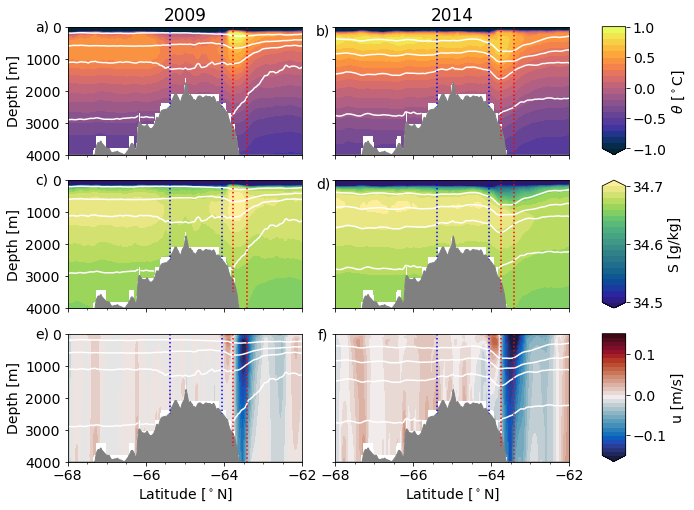

In [80]:
ymax=4000
fig,axes=plt.subplots(3,3,figsize=(10,8),gridspec_kw={'width_ratios':[1,1,0.1]})
sig0_clev=np.concatenate(([27.67],np.arange(27.7,27.8,0.01)))
ax=axes[0,0]
#ax.set_facecolor('gray')
ds.thetao.isel(t=0).where(ds.depth<ds.bathy_meter).plot.contourf(x="gphit",y="depth",ax=ax,vmin=-1,vmax=1,levels=21,cmap=cmo.thermal,add_colorbar=False)
ds.sig0.isel(t=0).where(ds.depth<ds.bathy_meter).plot.contour(x="gphit",y="depth",ax=ax,levels=sig0_clev,colors='w')
ax.fill_between(bat.nav_lat,bat.bathy_meter,ymax,color='gray')
ax.vlines(x=ds.gphit.isel(y_c=tc[0]),ymin=0,ymax=2500,color='b',linestyle=':')
ax.vlines(x=ds.gphit.isel(y_c=tc[-1]),ymin=0,ymax=2500,color='b',linestyle=':')
ax.vlines(x=ds.gphit.isel(y_c=ha[0]),ymin=0,ymax=3500,color='r',linestyle=':')
ax.vlines(x=ds.gphit.isel(y_c=ha[-1]),ymin=0,ymax=5000,color='r',linestyle=':')
ax.set_ylim(0,ymax)
ax.invert_yaxis()
ax.set_title('%d'%ds.year[0])
ax.set_xticks(minor_ticks, minor=True)
ax.set_ylabel('Depth [m]')
ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_xlim(-68,-62)
ax.text(-.11, 1, 'a)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize='14')

ax=axes[0,1]
#ax.set_facecolor('gray')
cbt=ds.thetao.isel(t=1).where(ds.depth<ds.bathy_meter).plot.contourf(x="gphit",y="depth",ax=ax,vmin=-1,vmax=1,levels=21,cmap=cmo.thermal,add_colorbar=False)
ds.sig0.isel(t=1).where(ds.depth<ds.bathy_meter).plot.contour(x="gphit",y="depth",ax=ax,levels=sig0_clev,colors='w')
ax.fill_between(bat.nav_lat,bat.bathy_meter,ymax,color='gray')
ax.vlines(x=ds.gphit.isel(y_c=tc[0]),ymin=0,ymax=2500,color='b',linestyle=':')
ax.vlines(x=ds.gphit.isel(y_c=tc[-1]),ymin=0,ymax=2500,color='b',linestyle=':')
ax.vlines(x=ds.gphit.isel(y_c=ha[0]),ymin=0,ymax=3500,color='r',linestyle=':')
ax.vlines(x=ds.gphit.isel(y_c=ha[-1]),ymin=0,ymax=5000,color='r',linestyle=':')
ax.set_ylim(0,ymax)
ax.set_xticks(minor_ticks, minor=True)
ax.invert_yaxis()
ax.set_title('%d'%ds.year[1])
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_xlim(-68,-62)
plt.colorbar(cbt,cax=axes[0,2],ticks=np.linspace(-1,1,5),label='$\\theta$ [$^\circ$C]')
ax.text(-.05, 0.97, 'b)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize='14')

ax=axes[1,0]
#ax.set_facecolor('gray')
ds.so.isel(t=0).where(ds.depth<ds.bathy_meter).plot.contourf(x="gphit",y="depth",ax=ax,vmin=34.5,vmax=34.7,levels=21,cmap=cmo.haline,add_colorbar=False)
ds.sig0.isel(t=0).where(ds.depth<ds.bathy_meter).plot.contour(x="gphit",y="depth",ax=ax,levels=sig0_clev,colors='w')
ax.fill_between(bat.nav_lat,bat.bathy_meter,ymax,color='gray')
ax.vlines(x=ds.gphit.isel(y_c=tc[0]),ymin=0,ymax=2500,color='b',linestyle=':')
ax.vlines(x=ds.gphit.isel(y_c=tc[-1]),ymin=0,ymax=2500,color='b',linestyle=':')
ax.vlines(x=ds.gphit.isel(y_c=ha[0]),ymin=0,ymax=3500,color='r',linestyle=':')
ax.vlines(x=ds.gphit.isel(y_c=ha[-1]),ymin=0,ymax=5000,color='r',linestyle=':')
ax.set_ylim(0,ymax)
ax.set_xticks(minor_ticks, minor=True)
ax.invert_yaxis()
ax.set_title('')
ax.set_ylabel('Depth [m]')
ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_xlim(-68,-62)
ax.text(-.11, 1,'c)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize='14')

ax=axes[1,1]
#ax.set_facecolor('gray')
cbs=ds.so.isel(t=1).where(ds.depth<ds.bathy_meter).plot.contourf(x="gphit",y="depth",ax=ax,vmin=34.5,vmax=34.7,levels=21,cmap=cmo.haline,add_colorbar=False)
ds.sig0.isel(t=1).where(ds.depth<ds.bathy_meter).plot.contour(x="gphit",y="depth",ax=ax,levels=sig0_clev,colors='w')
ax.fill_between(bat.nav_lat,bat.bathy_meter,ymax,color='gray')
ax.vlines(x=ds.gphit.isel(y_c=tc[0]),ymin=0,ymax=2500,color='b',linestyle=':')
ax.vlines(x=ds.gphit.isel(y_c=tc[-1]),ymin=0,ymax=2500,color='b',linestyle=':')
ax.vlines(x=ds.gphit.isel(y_c=ha[0]),ymin=0,ymax=3500,color='r',linestyle=':')
ax.vlines(x=ds.gphit.isel(y_c=ha[-1]),ymin=0,ymax=5000,color='r',linestyle=':')
ax.set_ylim(0,ymax)
ax.set_xticks(minor_ticks, minor=True)
ax.invert_yaxis()
ax.set_title('')
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_xlim(-68,-62)
plt.colorbar(cbs,cax=axes[1,2],ticks=np.linspace(34.5,34.7,3),label='S [g/kg]')
ax.text(-.05, 0.97, 'd)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize='14')

ax=axes[2,0]
#ax.set_facecolor('gray')
ds.uo.isel(t=0).where(ds.depth<ds.bathy_meter).plot.contourf(x="gphit",y="depth",ax=ax,vmin=-0.15,vmax=0.15,levels=31,cmap=cmo.balance,add_colorbar=False)
ds.sig0.isel(t=0).where(ds.depth<ds.bathy_meter).plot.contour(x="gphit",y="depth",ax=ax,levels=sig0_clev,colors='w')
ax.fill_between(bat.nav_lat,bat.bathy_meter,ymax,color='gray')
ax.vlines(x=ds.gphit.isel(y_c=tc[0]),ymin=0,ymax=2500,color='b',linestyle=':')
ax.vlines(x=ds.gphit.isel(y_c=tc[-1]),ymin=0,ymax=2500,color='b',linestyle=':')
ax.vlines(x=ds.gphit.isel(y_c=ha[0]),ymin=0,ymax=3500,color='r',linestyle=':')
ax.vlines(x=ds.gphit.isel(y_c=ha[-1]),ymin=0,ymax=5000,color='r',linestyle=':')
ax.set_ylim(0,ymax)
ax.set_xticks(minor_ticks, minor=True)
ax.invert_yaxis()
ax.set_title('')
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Latitude [$^\circ$N]')
ax.set_xlim(-68,-62)
ax.text(-.11, 1, 'e)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize='14')

ax=axes[2,1]
#ax.set_facecolor('gray')
cbu=ds.uo.isel(t=1).where(ds.depth<ds.bathy_meter).plot.contourf(x="gphit",y="depth",ax=ax,vmin=-0.15,vmax=0.15,levels=31,cmap=cmo.balance,add_colorbar=False)
ds.sig0.isel(t=1).where(ds.depth<ds.bathy_meter).plot.contour(x="gphit",y="depth",ax=ax,levels=sig0_clev,colors='w')
ax.fill_between(bat.nav_lat,bat.bathy_meter,ymax,color='gray')
ax.vlines(x=ds.gphit.isel(y_c=tc[0]),ymin=0,ymax=2500,color='b',linestyle=':')
ax.vlines(x=ds.gphit.isel(y_c=tc[-1]),ymin=0,ymax=2500,color='b',linestyle=':')
ax.vlines(x=ds.gphit.isel(y_c=ha[0]),ymin=0,ymax=3500,color='r',linestyle=':')
ax.vlines(x=ds.gphit.isel(y_c=ha[-1]),ymin=0,ymax=5000,color='r',linestyle=':')
ax.set_ylim(0,ymax)

ax.set_xticks(minor_ticks, minor=True)
ax.invert_yaxis()
ax.set_title('')
ax.set_ylabel('')
ax.set_xlabel('Latitude [$^\circ$N]')
ax.set_yticklabels([])
ax.set_xlim(-68,-62)
plt.colorbar(cbu,cax=axes[2,2],ticks=np.linspace(-0.10,0.10,3),label='u [m/s]',extend='neither')
ax.text(-.05, 0.99, 'f)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize='14')
plt.savefig('./TSU_sections_2009_2014.jpg',dpi=300)

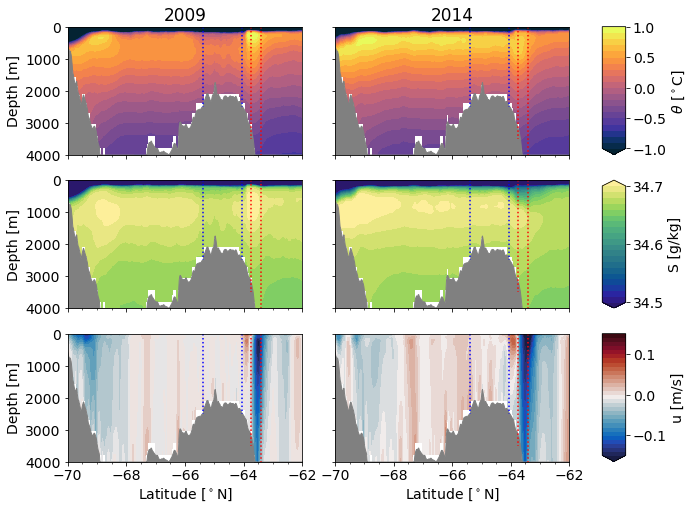

In [32]:
ymax=4000
fig,axes=plt.subplots(3,3,figsize=(10,8),gridspec_kw={'width_ratios':[1,1,0.1]})

ax=axes[0,0]
#ax.set_facecolor('gray')
ds.thetao.isel(t=0).where(ds.depth<ds.bathy_meter).plot.contourf(x="gphit",y="depth",ax=ax,vmin=-1,vmax=1,levels=21,cmap=cmo.thermal,add_colorbar=False)
ax.fill_between(bat.nav_lat,bat.bathy_meter,ymax,color='gray')
ax.vlines(x=ds.gphit.isel(y_c=tc[0]),ymin=0,ymax=2500,color='b',linestyle=':')
ax.vlines(x=ds.gphit.isel(y_c=tc[-1]),ymin=0,ymax=2500,color='b',linestyle=':')
ax.vlines(x=ds.gphit.isel(y_c=ha[0]),ymin=0,ymax=3500,color='r',linestyle=':')
ax.vlines(x=ds.gphit.isel(y_c=ha[-1]),ymin=0,ymax=5000,color='r',linestyle=':')
ax.set_ylim(0,ymax)
ax.invert_yaxis()
ax.set_title('%d'%ds.year[0])
ax.set_xticks(minor_ticks, minor=True)
ax.set_ylabel('Depth [m]')
ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_xlim(-70,-62)

ax=axes[0,1]
#ax.set_facecolor('gray')
cbt=ds.thetao.isel(t=1).where(ds.depth<ds.bathy_meter).plot.contourf(x="gphit",y="depth",ax=ax,vmin=-1,vmax=1,levels=21,cmap=cmo.thermal,add_colorbar=False)
ax.fill_between(bat.nav_lat,bat.bathy_meter,ymax,color='gray')
ax.vlines(x=ds.gphit.isel(y_c=tc[0]),ymin=0,ymax=2500,color='b',linestyle=':')
ax.vlines(x=ds.gphit.isel(y_c=tc[-1]),ymin=0,ymax=2500,color='b',linestyle=':')
ax.vlines(x=ds.gphit.isel(y_c=ha[0]),ymin=0,ymax=3500,color='r',linestyle=':')
ax.vlines(x=ds.gphit.isel(y_c=ha[-1]),ymin=0,ymax=5000,color='r',linestyle=':')
ax.set_ylim(0,ymax)
ax.set_xticks(minor_ticks, minor=True)
ax.invert_yaxis()
ax.set_title('%d'%ds.year[1])
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_xlim(-70,-62)
plt.colorbar(cbt,cax=axes[0,2],ticks=np.linspace(-1,1,5),label='$\\theta$ [$^\circ$C]')


ax=axes[1,0]
#ax.set_facecolor('gray')
ds.so.isel(t=0).where(ds.depth<ds.bathy_meter).plot.contourf(x="gphit",y="depth",ax=ax,vmin=34.5,vmax=34.7,levels=21,cmap=cmo.haline,add_colorbar=False)
ax.fill_between(bat.nav_lat,bat.bathy_meter,ymax,color='gray')
ax.vlines(x=ds.gphit.isel(y_c=tc[0]),ymin=0,ymax=2500,color='b',linestyle=':')
ax.vlines(x=ds.gphit.isel(y_c=tc[-1]),ymin=0,ymax=2500,color='b',linestyle=':')
ax.vlines(x=ds.gphit.isel(y_c=ha[0]),ymin=0,ymax=3500,color='r',linestyle=':')
ax.vlines(x=ds.gphit.isel(y_c=ha[-1]),ymin=0,ymax=5000,color='r',linestyle=':')
ax.set_ylim(0,ymax)
ax.set_xticks(minor_ticks, minor=True)
ax.invert_yaxis()
ax.set_title('')
ax.set_ylabel('Depth [m]')
ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_xlim(-70,-62)

ax=axes[1,1]
#ax.set_facecolor('gray')
cbs=ds.so.isel(t=1).where(ds.depth<ds.bathy_meter).plot.contourf(x="gphit",y="depth",ax=ax,vmin=34.5,vmax=34.7,levels=21,cmap=cmo.haline,add_colorbar=False)
ax.fill_between(bat.nav_lat,bat.bathy_meter,ymax,color='gray')
ax.vlines(x=ds.gphit.isel(y_c=tc[0]),ymin=0,ymax=2500,color='b',linestyle=':')
ax.vlines(x=ds.gphit.isel(y_c=tc[-1]),ymin=0,ymax=2500,color='b',linestyle=':')
ax.vlines(x=ds.gphit.isel(y_c=ha[0]),ymin=0,ymax=3500,color='r',linestyle=':')
ax.vlines(x=ds.gphit.isel(y_c=ha[-1]),ymin=0,ymax=5000,color='r',linestyle=':')
ax.set_ylim(0,ymax)
ax.set_xticks(minor_ticks, minor=True)
ax.invert_yaxis()
ax.set_title('')
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_xlim(-70,-62)
plt.colorbar(cbs,cax=axes[1,2],ticks=np.linspace(34.5,34.7,3),label='S [g/kg]')

ax=axes[2,0]
#ax.set_facecolor('gray')
ds.uo.isel(t=0).where(ds.depth<ds.bathy_meter).plot.contourf(x="gphit",y="depth",ax=ax,vmin=-0.15,vmax=0.15,levels=31,cmap=cmo.balance,add_colorbar=False)
ax.fill_between(bat.nav_lat,bat.bathy_meter,ymax,color='gray')
ax.vlines(x=ds.gphit.isel(y_c=tc[0]),ymin=0,ymax=2500,color='b',linestyle=':')
ax.vlines(x=ds.gphit.isel(y_c=tc[-1]),ymin=0,ymax=2500,color='b',linestyle=':')
ax.vlines(x=ds.gphit.isel(y_c=ha[0]),ymin=0,ymax=3500,color='r',linestyle=':')
ax.vlines(x=ds.gphit.isel(y_c=ha[-1]),ymin=0,ymax=5000,color='r',linestyle=':')
ax.set_ylim(0,ymax)
ax.set_xticks(minor_ticks, minor=True)
ax.invert_yaxis()
ax.set_title('')
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Latitude [$^\circ$N]')
ax.set_xlim(-70,-62)

ax=axes[2,1]
#ax.set_facecolor('gray')
cbu=ds.uo.isel(t=1).where(ds.depth<ds.bathy_meter).plot.contourf(x="gphit",y="depth",ax=ax,vmin=-0.15,vmax=0.15,levels=31,cmap=cmo.balance,add_colorbar=False)
ax.fill_between(bat.nav_lat,bat.bathy_meter,ymax,color='gray')
ax.vlines(x=ds.gphit.isel(y_c=tc[0]),ymin=0,ymax=2500,color='b',linestyle=':')
ax.vlines(x=ds.gphit.isel(y_c=tc[-1]),ymin=0,ymax=2500,color='b',linestyle=':')
ax.vlines(x=ds.gphit.isel(y_c=ha[0]),ymin=0,ymax=3500,color='r',linestyle=':')
ax.vlines(x=ds.gphit.isel(y_c=ha[-1]),ymin=0,ymax=5000,color='r',linestyle=':')
ax.set_ylim(0,ymax)
ax.set_xticks(minor_ticks, minor=True)
ax.invert_yaxis()
ax.set_title('')
ax.set_ylabel('')
ax.set_xlabel('Latitude [$^\circ$N]')
ax.set_yticklabels([])
ax.set_xlim(-70,-62)
plt.colorbar(cbu,cax=axes[2,2],ticks=np.linspace(-0.10,0.10,3),label='u [m/s]')

# Sea Ice Vorticity

In [4]:
path=('../../MAUD_RISE_config/maud_v4/m36_ke2/section/')

ds_09=xr.open_mfdataset(path+'Vort*_2009_m36.nc')
ds_09=ds_09.expand_dims(dim='t')
ds_09['year']=ds_09.t+2009
ds_09.coords['year']=ds_09.year

ds_14=xr.open_mfdataset(path+'Vort*_2014_m36.nc')
ds_14=ds_14.expand_dims(dim='t')
ds_14['year']=ds_14.t+2014
ds_14.coords['year']=ds_14.year

bat=xr.open_dataset('../../MAUD_RISE_config/maud_v4/m36_mask/1_domain_cfg_50levels_new.nc')
bat.coords['nav_lon']=bat.nav_lon.mean(dim='y')
bat.coords['nav_lat']=bat.nav_lat.mean(dim='x')
bat=bat.swap_dims({'x':'x_c','y':'y_c','z':'z_c'})

mask=xr.open_mfdataset('../../MAUD_RISE_config/maud_v4/m36_mask/mask*.nc')

ds_14=xr.merge((ds_14,bat.bathy_meter,mask))
ds=xr.concat((ds_09,ds_14),dim='t')
ds

<xarray.Dataset>
Dimensions:      (t: 2, x_c: 879, y_c: 804)
Coordinates:
    glamt        (y_c, x_c) float64 dask.array<chunksize=(804, 879), meta=np.ndarray>
    gphit        (y_c, x_c) float64 dask.array<chunksize=(804, 879), meta=np.ndarray>
    nav_lon      (x_c) float32 -5.111 -5.0 -4.972 -4.944 ... 19.31 19.33 19.36
    nav_lat      (y_c) float32 -70.54 -70.5 -70.49 ... -61.58 -61.57 -61.55
  * y_c          (y_c) int64 0 1 2 3 4 5 6 7 ... 796 797 798 799 800 801 802 803
  * x_c          (x_c) int64 0 1 2 3 4 5 6 7 ... 871 872 873 874 875 876 877 878
    year         (t) int64 2009 2014
Dimensions without coordinates: t
Data variables:
    bathy_meter  (y_c, x_c) float32 ...
    mask_ha_mod  (y_c, x_c) float64 dask.array<chunksize=(804, 879), meta=np.ndarray>
    mask_tc      (y_c, x_c) float64 dask.array<chunksize=(804, 879), meta=np.ndarray>
    mask_tr      (y_c, x_c) float64 dask.array<chunksize=(804, 879), meta=np.ndarray>
    mask_ha      (y_c, x_c) float64 dask.array<chunksize=(804, 879), meta=np.ndarray>
    vort_ice_ym  (t, y_c, x_c) float64 dask.array<chunksize=(1, 804, 879), meta=np.ndarray>

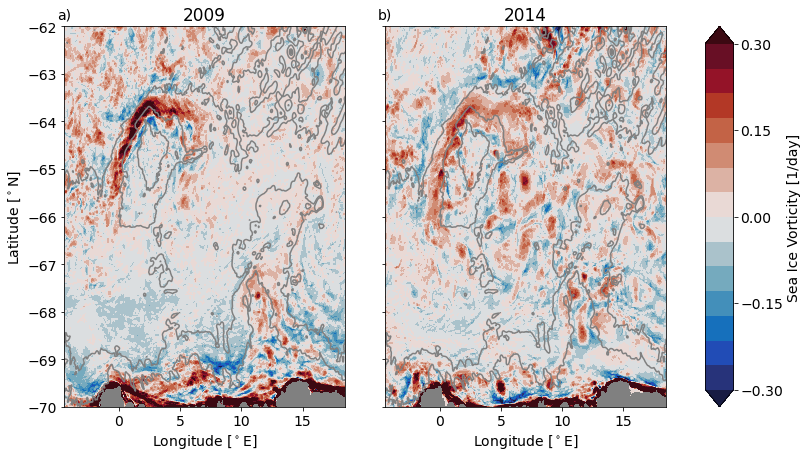

In [12]:
ymax=4000
vamax=0.3
vamin=-vamax
lev=15
fig,axes=plt.subplots(1,3,figsize=(12,7),gridspec_kw={'width_ratios':[1,1,0.1]})

ax=axes[0]
ds.vort_ice_ym.isel(t=0).plot.contourf(x="glamt",y="gphit",ax=ax,vmin=vamin,vmax=vamax,levels=lev,cmap=cmo.balance,add_colorbar=False)
ds.bathy_meter.plot.contour(x="glamt",y="gphit",ax=ax,levels=[2500,3500,5000],colors='grey')
ds.bathy_meter.where(ds.bathy_meter<1).plot.contourf(x="glamt",y="gphit",ax=ax,colors='gray',add_colorbar=False)
ax.set_xlim((-4.5,18.5))
ax.set_ylim(-70,-62)
ax.set_title('%d'%ds.year.isel(t=0))
ax.set_ylabel('Latitude [$^\circ$N]')
ax.set_xlabel('Longitude [$^\circ$E]')
ax.text(.0, 1.03, 'a)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize='14')
ax=axes[1]
cbv=ds.vort_ice_ym.isel(t=1).plot.contourf(x="glamt",y="gphit",ax=ax,vmin=vamin,vmax=vamax,levels=lev,cmap=cmo.balance,add_colorbar=False)
ds.bathy_meter.plot.contour(x="glamt",y="gphit",ax=ax,levels=[2500,3500,5000],colors='grey')
ds.bathy_meter.where(ds.bathy_meter<1).plot.contourf(x="glamt",y="gphit",ax=ax,colors='gray',add_colorbar=False)
ax.set_xlim((-4.5,18.5))
ax.set_ylim(-70,-62)
ax.set_title('%d'%ds.year.isel(t=1))
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_xlabel('Longitude [$^\circ$E]')
ax.text(.0, 1.03, 'b)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize='14')

plt.colorbar(cbv,cax=axes[2],ticks=np.arange(-0.3,0.45,0.15),label='Sea Ice Vorticity [1/day]')

plt.savefig('./seaice_vorticity_2009_2014_jas.jpg',dpi=300)

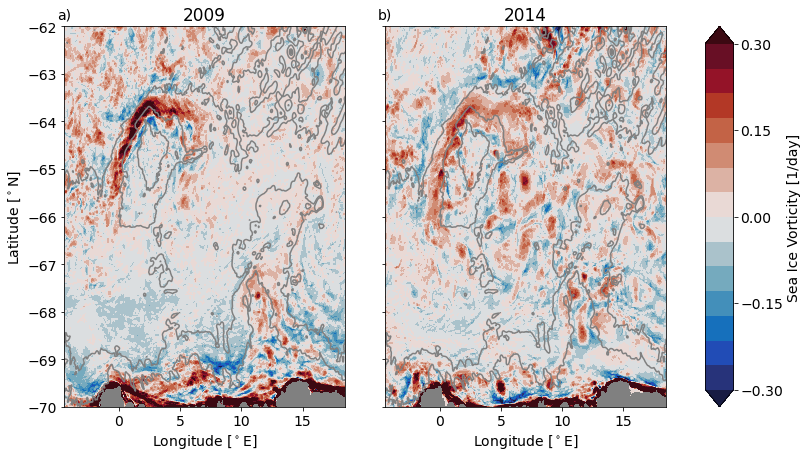

In [13]:
path=('../../MAUD_RISE_config/maud_v4/m36_ke2/section/')

ds_09=xr.open_mfdataset(path+'Vort*_2009_m36_fullyear.nc')
ds_09=ds_09.expand_dims(dim='t')
ds_09['year']=ds_09.t+2009
ds_09.coords['year']=ds_09.year

ds_14=xr.open_mfdataset(path+'Vort*_2014_m36_fullyear.nc')
ds_14=ds_14.expand_dims(dim='t')
ds_14['year']=ds_14.t+2014
ds_14.coords['year']=ds_14.year

bat=xr.open_dataset('../../MAUD_RISE_config/maud_v4/m36_mask/1_domain_cfg_50levels_new.nc')
bat.coords['nav_lon']=bat.nav_lon.mean(dim='y')
bat.coords['nav_lat']=bat.nav_lat.mean(dim='x')
bat=bat.swap_dims({'x':'x_c','y':'y_c','z':'z_c'})

mask=xr.open_mfdataset('../../MAUD_RISE_config/maud_v4/m36_mask/mask*.nc')

ds_14=xr.merge((ds_14,bat.bathy_meter,mask))
ds=xr.concat((ds_09,ds_14),dim='t')


ymax=4000
vamax=0.3
vamin=-vamax
lev=15
fig,axes=plt.subplots(1,3,figsize=(12,7),gridspec_kw={'width_ratios':[1,1,0.1]})

ax=axes[0]
ds.vort_ice_ym.isel(t=0).plot.contourf(x="glamt",y="gphit",ax=ax,vmin=vamin,vmax=vamax,levels=lev,cmap=cmo.balance,add_colorbar=False)
ds.bathy_meter.plot.contour(x="glamt",y="gphit",ax=ax,levels=[2500,3500,5000],colors='grey')
ds.bathy_meter.where(ds.bathy_meter<1).plot.contourf(x="glamt",y="gphit",ax=ax,colors='gray',add_colorbar=False)
ax.set_xlim((-4.5,18.5))
ax.set_ylim(-70,-62)
ax.set_title('%d'%ds.year.isel(t=0))
ax.set_ylabel('Latitude [$^\circ$N]')
ax.set_xlabel('Longitude [$^\circ$E]')
ax.text(.0, 1.03, 'a)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize='14')
ax=axes[1]
cbv=ds.vort_ice_ym.isel(t=1).plot.contourf(x="glamt",y="gphit",ax=ax,vmin=vamin,vmax=vamax,levels=lev,cmap=cmo.balance,add_colorbar=False)
ds.bathy_meter.plot.contour(x="glamt",y="gphit",ax=ax,levels=[2500,3500,5000],colors='grey')
ds.bathy_meter.where(ds.bathy_meter<1).plot.contourf(x="glamt",y="gphit",ax=ax,colors='gray',add_colorbar=False)
ax.set_xlim((-4.5,18.5))
ax.set_ylim(-70,-62)
ax.set_title('%d'%ds.year.isel(t=1))
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_xlabel('Longitude [$^\circ$E]')
ax.text(.0, 1.03, 'b)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize='14')
plt.colorbar(cbv,cax=axes[2],ticks=np.arange(-0.3,0.45,0.15),label='Sea Ice Vorticity [1/day]')
plt.savefig('./seaice_vorticity_2009_2014_fullyear.jpg',dpi=300)